<center><img src='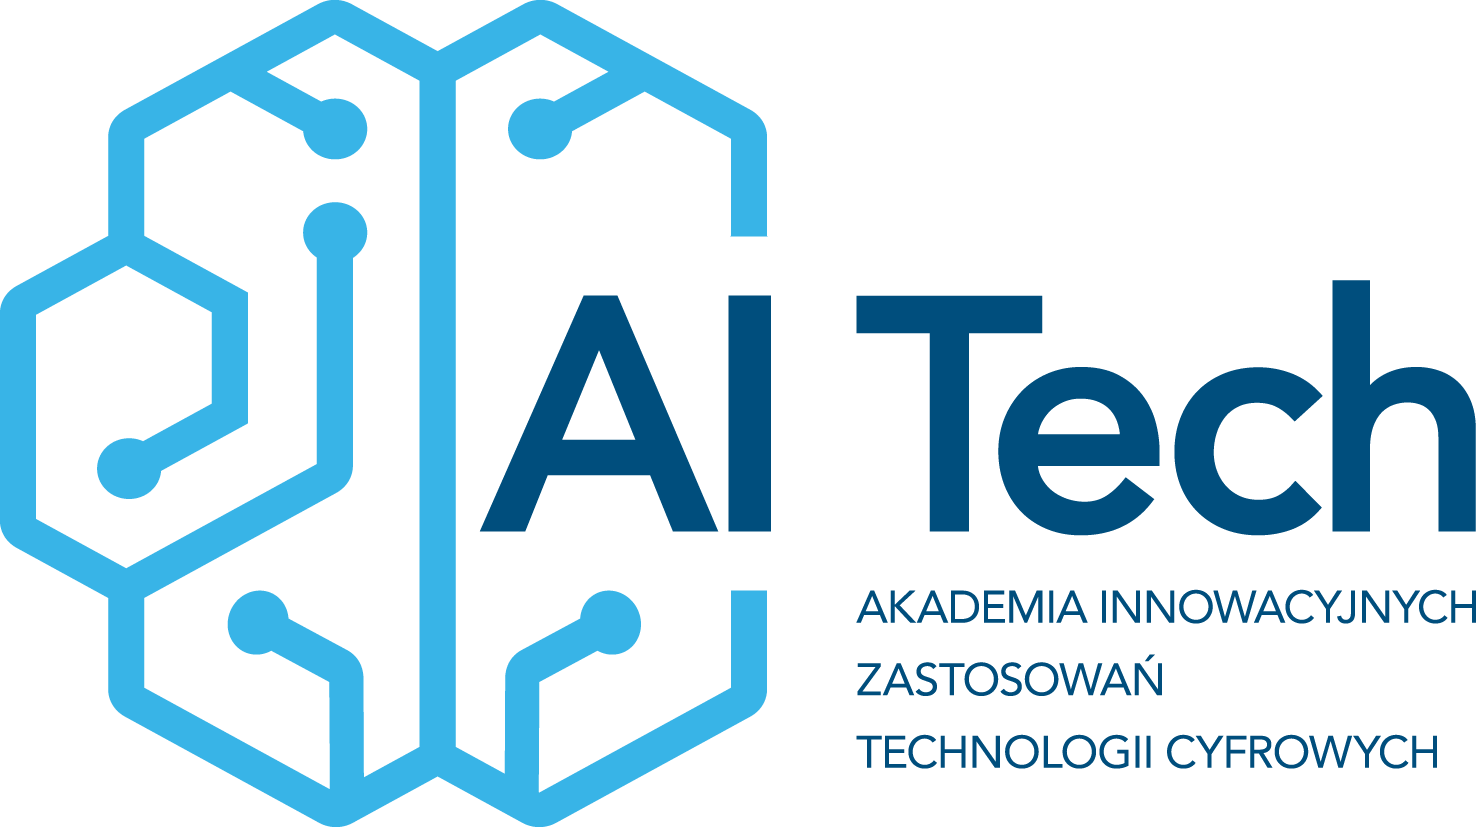
' height="60"></center>

AI TECH - Akademia Innowacyjnych Zastosowań Technologii Cyfrowych. Program Operacyjny Polska Cyfrowa na lata 2014-2020
<hr>

<center>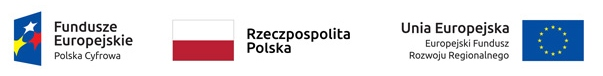</center>

<center>
Projekt współfinansowany ze środków Unii Europejskiej w ramach Europejskiego Funduszu Rozwoju Regionalnego
Program Operacyjny Polska Cyfrowa na lata 2014-2020,
Oś Priorytetowa nr 3 "Cyfrowe kompetencje społeczeństwa" Działanie  nr 3.2 "Innowacyjne rozwiązania na rzecz aktywizacji cyfrowej"
Tytuł projektu:  „Akademia Innowacyjnych Zastosowań Technologii Cyfrowych (AI Tech)”
    </center>

**Author: Tomasz Kanas**


# Distributing Gradient Descent
In this class we present how to distribute Gradient Descent.

We implement the algorithms in Python using Message Passing Interface (MPI). To test the algorithms we setup small cluster in Google Cloud. To make the deployment smoother, we automate it using Terraform and Ansible.

### Terraform and Ansible

[Terraform](https://www.terraform.io/) and [Ansible](https://www.ansible.com/) are tools based on the Infrastructure as a Code (IaC) principle. They allow us to automate the process of renting cloud resources (Terraform) and performing the setup and maintenance tasks on them (Ansible). In this lab we use them mainly to automate the process of setting up the cloud environment, so that you can experiment with distributed algorithms in actual distributed environment.

## Seting up MPI Cluster in Google Cloud
Almost the whole setup can be done in this notebook, but you are encouraged to do this setup locally or on the computer in the labs. Some steps tend not to work in Colab, and authorizing Colab to make changes in the cloud may not be the safest solution.

The Terraform and Google Cloud CLI should be installed on the lab computers (but not on the students machine), so if you work from the lab, you need only to install Ansible in a virtual environment.

This setup is inspired by this [tutorial](https://roparst.gricad-pages.univ-grenoble-alpes.fr/cloud-tutorials/mpi/). You are encouraged to read it to understand what is happening here.

### Installing Terraform

In [ ]:
# when doint this localy please activate sudo first, e.g., do "sudo ls"
!wget -O- https://apt.releases.hashicorp.com/gpg | gpg --dearmor | sudo tee /usr/share/keyrings/hashicorp-archive-keyring.gpg
!gpg --no-default-keyring --keyring /usr/share/keyrings/hashicorp-archive-keyring.gpg --fingerprint
!echo "deb [signed-by=/usr/share/keyrings/hashicorp-archive-keyring.gpg] https://apt.releases.hashicorp.com $(lsb_release -cs) main" | sudo tee /etc/apt/sources.list.d/hashicorp.list
!sudo apt update && sudo apt install terraform

--2024-10-20 21:30:31--  https://apt.releases.hashicorp.com/gpg
Resolving apt.releases.hashicorp.com (apt.releases.hashicorp.com)... 13.35.7.46, 13.35.7.69, 13.35.7.68, ...
Connecting to apt.releases.hashicorp.com (apt.releases.hashicorp.com)|13.35.7.46|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3980 (3.9K) [binary/octet-stream]
Saving to: ‘STDOUT’

-                   100%[===================>]   3.89K  --.-KB/s    in 0s      

2024-10-20 21:30:32 (1.47 GB/s) - written to stdout [3980/3980]

�Tj:/ȳh�h���Nf�����c��c����W{5!�Q����6&�Y�b[��Ұ�����Rώ��ԧ����a�}k57���R]�� �����#�z͸�=�~׳dL�у�E�v�����m�07�m�HuC�8'p$g>ҏ��D�XL�w�
c�4�A��k�f�ѨAXH�;��~�  �QHashiCorp Security (HashiCorp Package Signing) <security+packaging@hashicorp.com>�T >	
	�!y��eN\B��B����!�c��=		f� 
�D�9fS�u�!d�
c�� ��{����Ü���U�= �i6+���Xx�ĕ� ,�K��a%�	�<I�Z���A|�t�f�[�
�|{P��x ��tGS���u
-�jEٽ;�����i���M�[

#Install Ansible

In [1]:
!pip install ansible

### Install Google Cloud CLI

In [1]:
!curl https://packages.cloud.google.com/apt/doc/apt-key.gpg | sudo gpg --dearmor -o /usr/share/keyrings/cloud.google.gpg
!echo "deb [signed-by=/usr/share/keyrings/cloud.google.gpg] https://packages.cloud.google.com/apt cloud-sdk main" | sudo tee -a /etc/apt/sources.list.d/google-cloud-sdk.list
!sudo apt update && sudo apt install google-cloud-cli

gpg: nie można utworzyć ,,/usr/share/keyrings/cloud.google.gpg'': Brak dostępu
gpg: nie odnaleziono poprawnych danych w formacie OpenPGP.
gpg: zdjęcie opakowania ASCII nie powiodło się: Brak dostępu
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  1022  100  1022    0     0  20964      0 --:--:-- --:--:-- --:--:-- 21291
curl: (23) Failed writing body
tee: /etc/apt/sources.list.d/google-cloud-sdk.list: Brak dostępu
deb [signed-by=/usr/share/keyrings/cloud.google.gpg] https://packages.cloud.google.com/apt cloud-sdk main
Czytanie list pakietów... Gotowe
E: Nie udało się otworzyć pliku blokady /var/lib/apt/lists/lock - open (13: Brak dostępu)
E: Nie udało się zablokować katalogu /var/lib/apt/lists/
W: Problem przy odlinkowywaniu pliku /var/cache/apt/pkgcache.bin - RemoveCaches (13: Brak dostępu)
W: Problem przy odlinkowywaniu pliku /var/cache/apt/srcpkgcache.bin - RemoveCaches 

### Setup
Firstly we generate ssh key pair. Note: change the value of gcp_login variable to your cloud username (your google login where . and @ are replaced with _). Then, we download archive with the configuration files.

In [36]:
#Generate ssh key pair (NOTE: change the email to yours)
GCP_userID="michaltraczyk943"  # your GCP_userID is your google login where . and @ are replaced with _

!mkdir .ssh
!ssh-keygen -t ed25519 -f .ssh/id_ed25519 -N '' -C $GCP_userID

#Download configuration files
!wget -O cloud_mpi.zip https://drive.google.com/uc?id=1R0UbmwS_HKYer7LSsuL7Zw_aVhKq-0dI&export=download
!unzip cloud_mpi.zip

Generating public/private ed25519 key pair.
Your identification has been saved in .ssh/id_ed25519
Your public key has been saved in .ssh/id_ed25519.pub
The key fingerprint is:
SHA256:3LcRVE/3BLF00PTYkl2B/+z4REFW/ZGuzPbP7ebbDvY michaltraczyk943
The key's randomart image is:
+--[ED25519 256]--+
|            ..BX&|
|           . oo&B|
|            . B.O|
|       . .   . +o|
|        S . = ..o|
|           . B .o|
|            o +o.|
|             ..*=|
|               BE|
+----[SHA256]-----+
unzip:  cannot find or open cloud_mpi.zip, cloud_mpi.zip.zip or cloud_mpi.zip.ZIP.


### Setup environment variables
Fill the values of the environment values in the script below:
  - PROJECT_ID: You can find it in the home screen of the [Google Cloud Console](https://console.cloud.google.com/) - see the screenshot below.
  - GCP_userID: is your google login where . and @ are replaced with _ (you see it in the console).
  - GCP_privateKeyFile: The path to the private ssh key, you have created in the previous step.

NOTE: If you are doing this locally, edit and source the `setup.sh` file in the `cloud_mpi` directory and run it as `. ./setup.sh`.

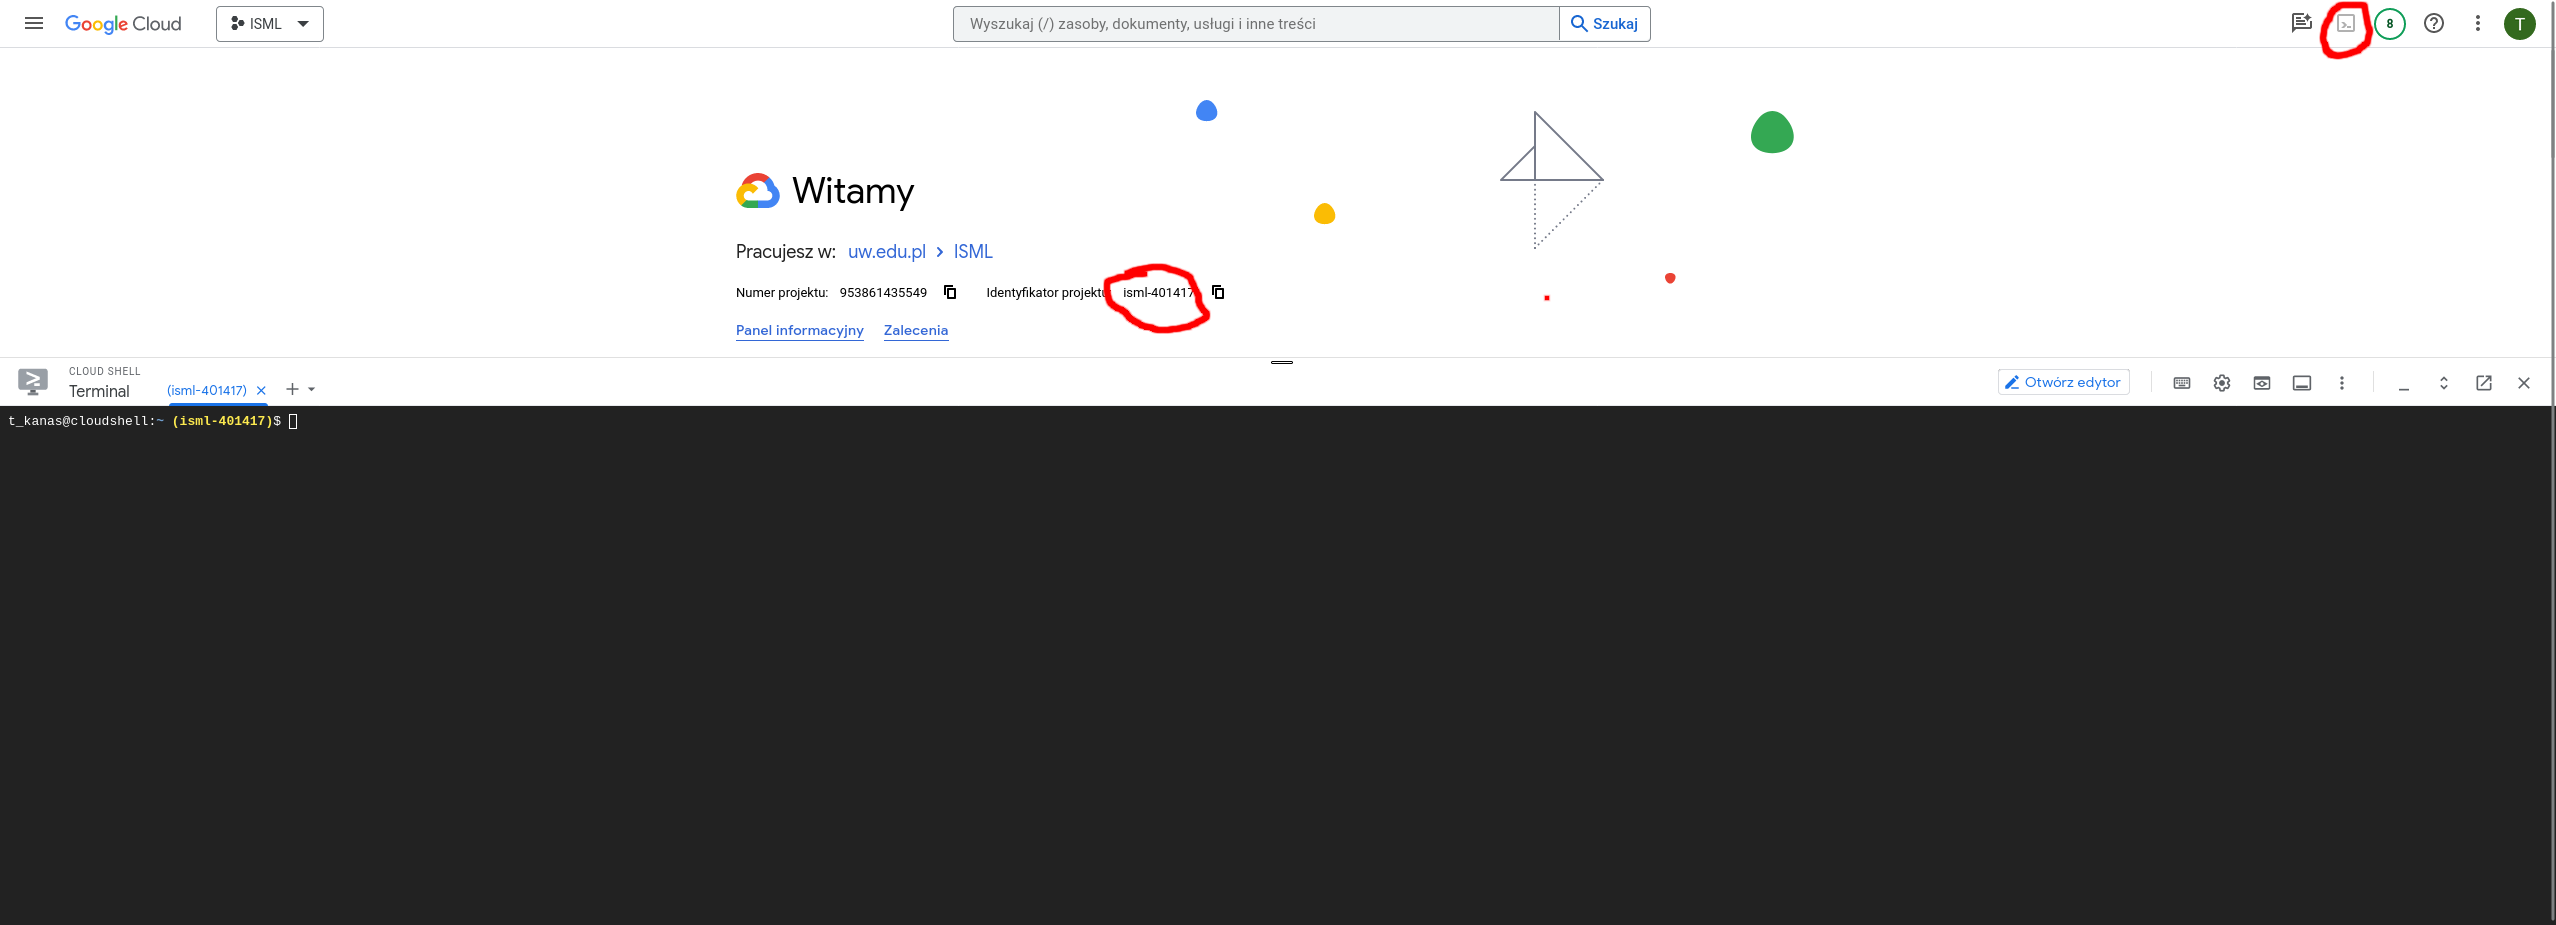

If you work in collab run this:

In [ ]:
!ls /content/.ssh/

id_ed25519  id_ed25519.pub


In [7]:
!ssh-keygen -t ed25519 -f .ssh/id_ed25519 -N '' -C $GCP_userID

Generating public/private ed25519 key pair.
.ssh/id_ed25519 already exists.
Overwrite (y/n)? ^C


In [19]:
PROJECT_ID="vivid-env-438608-i4"
SERVICE_NAME="lsml-mpi"
%env PROJECT_ID=$PROJECT_ID
%env SERVICE_NAME=$SERVICE_NAME
%env GCP_userID=$GCP_userID
%env GCP_privateKeyFile=.ssh/id_ed25519

### Terrform setup variabless
# Name of your GCP project
%env TF_VAR_project=$PROJECT_ID
# Name of your selected GCP region
%env TF_VAR_region=europe-central2
# Name of your selected GCP zone
%env TF_VAR_zone=europe-central2-a

### Other variables used by Terrform
# Number of VMs created
%env TF_VAR_machineCount=3
# VM type
%env TF_VAR_machineType=e2-medium
# Prefix for you VM instances
%env TF_VAR_instanceName=tf-instance
# Prefix of your GCP deployment key
TF_VAR_deployKeyName = "../" + SERVICE_NAME + ".json"
%env TF_VAR_deployKeyName=$TF_VAR_deployKeyName

env: PROJECT_ID=vivid-env-438608-i4
env: SERVICE_NAME=lsml-mpi
env: GCP_userID=michaltraczyk943_gmail_com
env: GCP_privateKeyFile=.ssh/id_ed25519
env: TF_VAR_project=vivid-env-438608-i4
env: TF_VAR_region=europe-central2
env: TF_VAR_zone=europe-central2-a
env: TF_VAR_machineCount=3
env: TF_VAR_machineType=e2-medium
env: TF_VAR_instanceName=tf-instance
env: TF_VAR_deployKeyName=../lsml-mpi.json


### Log in to the Google Cloud
If you are doing this locally, instead run: `gcloud init`.

In [9]:
from google.colab import auth
auth.authenticate_user()

ModuleNotFoundError: No module named 'google'

In [14]:
#Google Cloud Setup
!gcloud config set project $PROJECT_ID
!gcloud services enable iam.googleapis.com
!gcloud services enable compute.googleapis.com

/bin/bash: linia 1: gcloud: nie znaleziono polecenia


/bin/bash: linia 1: gcloud: nie znaleziono polecenia
/bin/bash: linia 1: gcloud: nie znaleziono polecenia


### Set the service account and create the key
NOTE: For some reason the following commands may not work in the colab. If it is the case, log in to the [Google Cloud Console](https://console.cloud.google.com/) and run them from the Cloud Shell (button is in the top right corner). Then download the `lsml-mpi.json` file and upload it into colab (to the base directory).

IMPORTANT: In both cases, you want to backup the `isml-mpi.json` file, to be able to recover this session (files in Colab aren't persistent).

In [ ]:
!gcloud iam service-accounts create $SERVICE_NAME
!gcloud projects add-iam-policy-binding $PROJECT_ID --member serviceAccount:$SERVICE_NAME@$PROJECT_ID.iam.gserviceaccount.com --role roles/editor
!gcloud iam service-accounts keys create ./$SERVICE_NAME.json --iam-account $SERVICE_NAME@$PROJECT_ID.iam.gserviceaccount.com

Created service account [lsml-mpi].
Updated IAM policy for project [bml-project-2].
bindings:
- members:
  - serviceAccount:service-831603756727@compute-system.iam.gserviceaccount.com
  role: roles/compute.serviceAgent
- members:
  - serviceAccount:831603756727-compute@developer.gserviceaccount.com
  - serviceAccount:831603756727@cloudservices.gserviceaccount.com
  - serviceAccount:lsml-mpi@bml-project-2.iam.gserviceaccount.com
  role: roles/editor
- members:
  - user:gim.jakubk@gmail.com
  role: roles/owner
etag: BwYk71eSDrA=
version: 1
created key [3fa32b4eee82da79dd27b35c171673f0292863f2] of type [json] as [./lsml-mpi.json] for [lsml-mpi@bml-project-2.iam.gserviceaccount.com]


In [63]:
# run output of this cell in Cloud Shell in case the above doesn't work in Colab
!echo gcloud iam service-accounts create $SERVICE_NAME
!echo gcloud projects add-iam-policy-binding $PROJECT_ID --member serviceAccount:$SERVICE_NAME@$PROJECT_ID.iam.gserviceaccount.com --role roles/editor
!echo gcloud iam service-accounts keys create ./$SERVICE_NAME.json --iam-account $SERVICE_NAME@$PROJECT_ID.iam.gserviceaccount.com

gcloud iam service-accounts create lsml-mpi


gcloud projects add-iam-policy-binding vivid-env-438608-i4 --member serviceAccount:lsml-mpi@vivid-env-438608-i4.iam.gserviceaccount.com --role roles/editor
gcloud iam service-accounts keys create ./lsml-mpi.json --iam-account lsml-mpi@vivid-env-438608-i4.iam.gserviceaccount.com


Now we need to pass your public key to the Google Cloud Metadata. Terraform can do it, using the file we create using this script.

IMPORTANT: This method will remove all your existing metadata ssh keys. If you don't want to lose them, add the key manually in the [Google Cloud Console](https://console.cloud.google.com/compute/metadata) instead.

In [16]:
!cd cloud_mpi && ./gen_transform_key.sh

cat: /content/.ssh/id_ed25519.pub: Nie ma takiego pliku ani katalogu


### Run Terraform

In [17]:
#Initialize terraform
!cd cloud_mpi && terraform init

Initializing the backend...
╷
│ Error: Terraform encountered problems during initialisation, including problems
│ with the configuration, described below.
│ 
│ The Terraform configuration must be valid before initialization so that
│ Terraform can determine which modules and providers need to be installed.
│ 
│ 
╵
╷
│ Error: Unterminated template string
│ 
│   on transform_key.tf line 7, in resource "google_compute_project_metadata" "default":
│    4:       michaltraczyk943_gmail_com:    EOF
│    5:   }
│    6: }
│ 
│ No closing marker was found for the string.
╵


In [ ]:
#Verify Configuration (IMPORTANT: look at the output if everything is correct: 3 VMs, and metadata)
!cd cloud_mpi && terraform plan


Terraform used the selected providers to generate the following execution plan. Resource actions are indicated with the following symbols:
  + create

Terraform will perform the following actions:

  # google_compute_instance.vm_instance[0] will be created
  + resource "google_compute_instance" "vm_instance" {
      + can_ip_forward       = false
      + cpu_platform         = (known after apply)
      + current_status       = (known after apply)
      + deletion_protection  = false
      + effective_labels     = (known after apply)
      + guest_accelerator    = (known after apply)
      + id                   = (known after apply)
      + instance_id          = (known after apply)
      + label_fingerprint    = (known after apply)
      + machine_type         = "e2-medium"
      + metadata_fingerprint = (known after apply)
      + min_cpu_platform     = (known after apply)
      + name                 = "tf-instance-0"
      + project              = "bml-project-2"
      + self_link

In [ ]:
#Launch the deployment
!cd cloud_mpi && echo "yes" | terraform apply


Terraform used the selected providers to generate the following execution plan. Resource actions are indicated with the following symbols:
  + create

Terraform will perform the following actions:

  # google_compute_instance.vm_instance[0] will be created
  + resource "google_compute_instance" "vm_instance" {
      + can_ip_forward       = false
      + cpu_platform         = (known after apply)
      + current_status       = (known after apply)
      + deletion_protection  = false
      + effective_labels     = (known after apply)
      + guest_accelerator    = (known after apply)
      + id                   = (known after apply)
      + instance_id          = (known after apply)
      + label_fingerprint    = (known after apply)
      + machine_type         = "e2-medium"
      + metadata_fingerprint = (known after apply)
      + min_cpu_platform     = (known after apply)
      + name                 = "tf-instance-0"
      + project              = "bml-project-2"
      + self_link

### Install MPI using Ansible
Locally in the `run_ansible.sh` file. This step may take some time (about 5 min) - you can spend this time reading the section about distributing SGD, or [this](https://roparst.gricad-pages.univ-grenoble-alpes.fr/cloud-tutorials/mpi/) guide to understand what those commands do!

In [ ]:
#Use Ansible to configure the machines
!cd cloud_mpi && ./parse-tf-state.py
!cd cloud_mpi && ansible-playbook --key-file $GCP_privateKeyFile -i ./hosts install_mpi.yml
!cd cloud_mpi && ansible-playbook --key-file $GCP_privateKeyFile -i ./hosts config_ssh.yml
!cd cloud_mpi && ansible-playbook --key-file $GCP_privateKeyFile -i ./hosts nfs.yml

tf-instance-0 (IP: 34.118.113.55)
tf-instance-1 (IP: 34.118.9.127)
tf-instance-2 (IP: 34.116.244.28)

PLAY [mpi_nodes] ***************************************************************

TASK [Gathering Facts] *********************************************************
[WARNING]: Platform linux on host 34.116.244.28 is using the discovered Python
interpreter at /usr/bin/python3.9, but future installation of another Python
interpreter could change the meaning of that path. See
https://docs.ansible.com/ansible-
core/2.17/reference_appendices/interpreter_discovery.html for more information.
ok: [34.116.244.28]
[WARNING]: Platform linux on host 34.118.113.55 is using the discovered Python
interpreter at /usr/bin/python3.9, but future installation of another Python
interpreter could change the meaning of that path. See
https://docs.ansible.com/ansible-
core/2.17/reference_appendices/interpreter_discovery.html for more information.
ok: [34.118.113.55]
[WARNING]: Platform linux on host 34.118.9.12

### Test the installation
If you did the setup locally, you can now return to the notebook, you need to setup the environment variables (few cells up), create the `cloud_mpi` folder, upload the `hosts` file, and the `buffer` directory and invoke the command below. You can also continue locally.

Below there is a utility script, that will send your code to one of the cloud VMs (first argument is the filename) and then invoke a command (second argument) on this machine.

If you work locally, it is also provided in the `mpi_run_python.py` script.

In [ ]:
!chmod 0600 cloud_mpi/buffer/id_rsa

In [ ]:
# Make sure you have a known_hosts file
!mkdir /root/.ssh/
!touch /root/.ssh/known_hosts

mkdir: cannot create directory ‘/root/.ssh/’: File exists


In [76]:
import os
import sys
import argparse
import subprocess

def mpi_run_python(script, command):
    guser = os.environ['GCP_userID']
    IPs= []
    print("\n ### collect list of IP addresses ###")
    with open('cloud_mpi/hosts') as hostfile:
        record_ip=False
        for line in hostfile:
            clean_line=line.rstrip()
            if clean_line == "[mpi_nodes]":
                record_ip = True
            elif record_ip:
                if not clean_line:
                    break
                else:
                    print(clean_line)
                    IPs.append(clean_line)
    
    # copy source file to one of the nodes
    print("\n ### copy source code to node {} ###".format(IPs[0]))
    p = subprocess.run("scp -i {0} {1} {2}@{3}:./".format("./cloud_mpi/.ssh/id_ed25519", script, guser, IPs[0]), shell=True, text=True, stdout=subprocess.PIPE, stderr=subprocess.STDOUT)
    print(p.stdout)
    p.check_returncode()

    # Exec the mpi program
    print("\n ### Execution of the provided command: {0} ###".format(command))
    p = subprocess.run("ssh -i {0} {1}@{2} \"{3}\"".format("./cloud_mpi/.ssh/id_ed25519", guser, IPs[0], command), shell=True, text=True, stdout=subprocess.PIPE, stderr=subprocess.STDOUT)
    print(p.stdout)
    p.check_returncode()
    # os.system("ssh -i {0} {1}@{2} \"{3} --hostfile hostfile_mpi --mca btl_base_warn_component_unused 0 ./{4}\"".format("buffer/id_rsa", guser, IPs[0], nb_ps, execfile))


The code below is basic example of point-to-point communication, to verify that the setup works (you should see both send and receive message in the output).

In [77]:
%%file test.py
from mpi4py import MPI

comm = MPI.COMM_WORLD
rank = comm.Get_rank()

if rank == 0:
    data = {'a': 7, 'b': 3.14}
    comm.send(data, dest=1, tag=11)
    print(f"Sent data {data} from rank {rank}")
elif rank == 1:
    data = comm.recv(source=0, tag=11)
    print(f"Received data {data} in rank {rank}")

Overwriting test.py


Below we invoke our utility script, providing the file we created above, and a command that will execute this script by MPI. The provided flags mean:
- `--hostfile` is a file that describes our cluster, in this case it was created by Ansible in every VM.
- `-n` number of MPI threads to create - with our configuration it will spawn one thread on every VM.

In [78]:
mpi_run_python("test.py", "mpiexec --hostfile hostfile_mpi -n 3 python3 test.py")


 ### collect list of IP addresses ###
34.118.96.105
34.116.238.184
34.118.13.252

 ### copy source code to node 34.118.96.105 ###


 ### Execution of the provided command: mpiexec --hostfile hostfile_mpi -n 3 python3 test.py ###
Sent data {'a': 7, 'b': 3.14} from rank 0
Received data {'a': 7, 'b': 3.14} in rank 1



If you receive an error message: "Host key authentication failed", try those commands (with the IP of the machine the script is sending the code to)

In [ ]:
!ssh-keygen -f "/root/.ssh/known_hosts" -R "34.116.254.114"
!ssh-keyscan 34.116.254.114 | tee -a ~/.ssh/known_hosts

### MPI

MPI (Message Passing Interface) is a library used to write distributed algorithms. It handles efficient communication between processes that may be distributed among different machines and colocated on one machine.

In this lab we use MPI only to demonstrate how to write the presented algorithms, so you will only need some basic usage examples. This [tutorial](https://rabernat.github.io/research_computing/parallel-programming-with-mpi-for-python.html) presents most features that will be needed in this lab. You may also find the `mpi4py` (MPI package for python) [documentation](https://mpi4py.readthedocs.io/en/stable/index.html) handy.

## Distributing the Gradient Descent
### Model: multivariate linear regression
For simplicity we will use a multivariate linear regression model, and for data, we will train it on a random data sampled from Normal distribution. Below you have a simple sequential implementation of gradient descent for this model, that we will use as a baseline.

In [79]:
#We need only auto-differentiation, so we will use a smaller library (and pytorch doesn't fit on our cloud machines)
!pip install mygrad

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.8/172.8 kB 3.2 MB/s eta 0:00:00a 0:00:01


In [80]:
import numpy as np
import mygrad as mg

np.set_printoptions(precision=3)
np.set_printoptions(suppress=True)

SEED = 42
np.random.seed(SEED)

TRAINING_DATASET_SIZE = 3000
FEATURES = 6

X_numpy = np.random.multivariate_normal(np.arange(FEATURES), np.eye(FEATURES), TRAINING_DATASET_SIZE)
X_train = mg.tensor(X_numpy).reshape(TRAINING_DATASET_SIZE, FEATURES)
# The hidden coefficients, that model is supposed to learn
COEFFICIENTS = np.array([6, 5, 4, 3, 2, 1], dtype=np.float64)
# Matrix multiplication
y_numpy = X_numpy @ COEFFICIENTS
y_train = mg.tensor(y_numpy)

#Initial solution
w_numpy = np.random.randn(FEATURES)

w = mg.tensor(w_numpy, dtype=np.float64)

def forward(w, X):
  return (X @ w).reshape(X.shape[0])


In [81]:
EPOCHS = 200
LEARNING_RATE = 0.01

for epoch in range(EPOCHS):
  y_est = forward(w, X_train)
  loss = ((y_train - y_est) ** 2).sum() / TRAINING_DATASET_SIZE #MSE
  loss.backward()

  w -= LEARNING_RATE * w.grad
  w.null_grad()

w.data

array([5.909, 4.915, 3.942, 2.979, 2.03 , 1.029])

Note, that with the provided parameters, the iteration has *almost* converged - those numbers we can use later to verify, that our distributed algorithms produce exactly the same results.

### Gradient Accumulation
We will start with very simple concept:
1. Distribute data equally among the nodes.
2. Perform one epoch on each machine.
3. Sum the gradients: use [`Reduce`](https://mpi4py.readthedocs.io/en/stable/reference/mpi4py.MPI.Comm.html?highlight=reduce#mpi4py.MPI.Comm.Reduce) MPI method to compute the sum of gradients in the 0-th node, and then [`Bcast`](https://mpi4py.readthedocs.io/en/stable/reference/mpi4py.MPI.Comm.html?highlight=bcast#mpi4py.MPI.Comm.Bcast) method, to broadcast the accumulated gradients to all of the nodes.
4. Repeat this for all the epochs.

Implement this algorithm by extending the code cell below:


In [92]:
%%file sgd_accumulate.py
import numpy as np
import mygrad as mg
from mpi4py import MPI

np.set_printoptions(precision=3)
np.set_printoptions(suppress=True)

def forward(w, X):
  return (X @ w).reshape(X.shape[0])

def mse(y, y_est):
  err = y - y_est
  return (err ** 2).mean()

comm = MPI.COMM_WORLD
rank = comm.Get_rank()
NODES = comm.Get_size()

SEED = 42
np.random.seed(SEED)

TRAINING_DATASET_SIZE = 3000
FEATURES = 6

LOCAL_DATASET_SIZE = int(TRAINING_DATASET_SIZE / NODES)

data = None
w_numpy = np.empty(FEATURES)
if rank == 0:
  #Let's suppose that we start with all the data on one machine
  X_numpy = np.random.multivariate_normal(np.arange(FEATURES), np.eye(FEATURES), TRAINING_DATASET_SIZE)
  # The hidden coefficients, that model is supposed to learn
  COEFFICIENTS = np.array([6, 5, 4, 3, 2, 1], dtype=np.float64)
  # Matrix multiplication
  y_numpy = X_numpy @ COEFFICIENTS
  w_numpy = np.random.randn(FEATURES)
  # Append y to X to send everything in one batch
  data = np.concatenate((X_numpy, y_numpy[:,None]), axis=1)

recvbuf = np.empty(LOCAL_DATASET_SIZE * (FEATURES + 1), dtype=np.float64) # allocate space for recvbuf - need FEATURES columns for features, and one for y
# Scatter distributes equal shard of data to every node (here we assume that LOCAL_DATASET_SIZE is divisible by NODES), root=0 means that initially the data is on the node 0
comm.Scatter(data, recvbuf, root=0)
# Bcast sends the data from the root (0) node to all the nodes (we need to distribute the initial state)
comm.Bcast(w_numpy, root=0)
data = recvbuf.reshape(LOCAL_DATASET_SIZE, FEATURES + 1)
X_numpy = data[:,:-1]
y_numpy = data[:,-1]
X_train = mg.tensor(X_numpy).reshape(LOCAL_DATASET_SIZE, FEATURES)
y_train = mg.tensor(y_numpy)
w = mg.tensor(w_numpy, dtype=np.float64)

EPOCHS = 200
LEARNING_RATE = 0.01

for epoch in range(EPOCHS):
  y_est = forward(w, X_train)
  loss = mse(y_train, y_est)
  loss.backward()
  local_gradient = np.array(w.grad)
  if rank == 0:
    sum_gradient = np.empty_like(local_gradient)
  else:
    sum_gradient = None
  comm.Reduce(local_gradient, sum_gradient, op=MPI.SUM, root=0)
  sum_gradient = comm.bcast(sum_gradient, root=0)
  w.data = w.data - LEARNING_RATE * sum_gradient / NODES
  w.null_grad()

#At the end every node should have the same coefficients
print(f"rank = {rank}, data = {w.data}")

Overwriting sgd_accumulate.py


In [93]:
mpi_run_python("sgd_accumulate.py", "mpiexec --hostfile hostfile_mpi -n 3 python3 sgd_accumulate.py")


 ### collect list of IP addresses ###
34.118.96.105
34.116.238.184
34.118.13.252

 ### copy source code to node 34.118.96.105 ###


 ### Execution of the provided command: mpiexec --hostfile hostfile_mpi -n 3 python3 sgd_accumulate.py ###
rank = 0, data = [5.909 4.915 3.942 2.979 2.03  1.029]
rank = 1, data = [5.909 4.915 3.942 2.979 2.03  1.029]
rank = 2, data = [5.909 4.915 3.942 2.979 2.03  1.029]



You should see the same state in every node at the end, and the state should match exactly the one in sequential version.

### Parallelizing the communication of the gradients
You might have noticed, that the previous algorithm has problem with scalability: every machine sends its gradient to the machine with rank 0, and then this machine sends accumulated gradient to all machines.

Try to figure it out how we can do this more efficiently before reading the next cell.

#### Algorithm

We will place the machines on the cycle and each machine will send its gradient to the next machine on the cycle (and receive from the previous one).

Then each machine will add its gradient to the received gradient, and in the next iteration will send the sum of the gradients.

We need to perform the same number of iterations as we have machines minus one.

For visualization, see the image below.

<img src="https://i.imgur.com/vHfxzQt.png"/>

Implement this algorithm below. Note that the [`Send`](https://mpi4py.readthedocs.io/en/stable/reference/mpi4py.MPI.Comm.html?highlight=Send#mpi4py.MPI.Comm.Send) and [`Recv`](https://mpi4py.readthedocs.io/en/stable/reference/mpi4py.MPI.Message.html?highlight=Recv#mpi4py.MPI.Message.Recv) methods are blocking, so to avoid deadlock you need either:
- On even nodes first `Send` then `Recv` and on the odd nodes first `Recv` then `Send`.
- Use the [`Sendrecv`](https://mpi4py.readthedocs.io/en/stable/reference/mpi4py.MPI.Comm.html?highlight=SendRecv#mpi4py.MPI.Comm.Sendrecv) method that does both send and receive in parallel.

In [117]:
%%file sgd_allreduce.py
import numpy as np
import mygrad as mg
from mpi4py import MPI

np.set_printoptions(precision=3)
np.set_printoptions(suppress=True)

def forward(w, X):
  return (X @ w).reshape(X.shape[0])

def mse(y, y_est):
  err = y - y_est
  return (err ** 2).mean()

comm = MPI.COMM_WORLD
rank = comm.Get_rank()
NODES = comm.Get_size()

SEED = 42
np.random.seed(SEED)

TRAINING_DATASET_SIZE = 3000
FEATURES = 6

LOCAL_DATASET_SIZE = int(TRAINING_DATASET_SIZE / NODES)

data = None
w_numpy = np.empty(FEATURES)
if rank == 0:
  #Let's suppose that we start with all the data on one machine
  X_numpy = np.random.multivariate_normal(np.arange(FEATURES), np.eye(FEATURES), TRAINING_DATASET_SIZE)
  # The hidden coefficients, that model is supposed to learn
  COEFFICIENTS = np.array([6, 5, 4, 3, 2, 1], dtype=np.float64)
  # Matrix multiplication
  y_numpy = X_numpy @ COEFFICIENTS
  w_numpy = np.random.randn(FEATURES)
  data = np.concatenate((X_numpy, y_numpy[:,None]), axis=1)

recvbuf = np.empty(LOCAL_DATASET_SIZE * (FEATURES + 1), dtype=np.float64) # allocate space for recvbuf
comm.Scatter(data, recvbuf, root=0)
comm.Bcast(w_numpy, root=0)
data = recvbuf.reshape(LOCAL_DATASET_SIZE, FEATURES + 1)
X_numpy = data[:,:-1]
y_numpy = data[:,-1]
X_train = mg.tensor(X_numpy).reshape(LOCAL_DATASET_SIZE, FEATURES)
y_train = mg.tensor(y_numpy)
w = mg.tensor(w_numpy, dtype=np.float64)

EPOCHS = 200
LEARNING_RATE = 0.01

for epoch in range(EPOCHS):
    y_est = forward(w, X_train)
    loss = mse(y_train, y_est)
    loss.backward()
    local_gradient = np.array(w.grad)
    accumulated_gradient = local_gradient.copy()
    send_rank = (rank + 1) % NODES
    recv_rank = (rank - 1 + NODES) % NODES
    received_gradient = np.empty_like(local_gradient)
    
    if rank % 2 == 0:
        comm.Send(accumulated_gradient, send_rank)
        comm.Recv(received_gradient, recv_rank)
    else:
        comm.Recv(received_gradient, recv_rank)
        comm.Send(accumulated_gradient, send_rank)
    
    accumulated_gradient += received_gradient
    
    w.data = w.data - LEARNING_RATE * accumulated_gradient / NODES
    w.null_grad()

#At the end every node should have the same coefficients
print(f"rank = {rank}, data = {w.data}")

Overwriting sgd_allreduce.py


In [118]:
mpi_run_python("sgd_allreduce.py", "mpiexec --hostfile hostfile_mpi -n 3 python3 sgd_allreduce.py")


 ### collect list of IP addresses ###
34.118.96.105
34.116.238.184
34.118.13.252

 ### copy source code to node 34.118.96.105 ###


 ### Execution of the provided command: mpiexec --hostfile hostfile_mpi -n 3 python3 sgd_allreduce.py ###
Traceback (most recent call last):
  File "/home/michaltraczyk943/sgd_allreduce.py", line 63, in <module>
    comm.Send(sendbuf=accumulated_gradient, dest=send_rank)
Traceback (most recent call last):
  File "/home/michaltraczyk943/sgd_allreduce.py", line 66, in <module>
  File "src/mpi4py/MPI.src/Comm.pyx", line 408, in mpi4py.MPI.Comm.Send
TypeError: Send() takes at least 2 positional arguments (0 given)
    comm.Recv(recvbuf=received_gradient, source=recv_rank)
  File "src/mpi4py/MPI.src/Comm.pyx", line 426, in mpi4py.MPI.Comm.Recv
Traceback (most recent call last):
  File "/home/michaltraczyk943/sgd_allreduce.py", line 63, in <module>
    comm.Send(sendbuf=accumulated_gradient, dest=send_rank)
  File "src/mpi4py/MPI.src/Comm.pyx", line 408, in mpi

CalledProcessError: Command 'ssh -i ./cloud_mpi/.ssh/id_ed25519 michaltraczyk943@34.118.96.105 "mpiexec --hostfile hostfile_mpi -n 3 python3 sgd_allreduce.py"' returned non-zero exit status 1.

Again, verify that all nodes have the same coefficients at the end, and those coefficients are equal to the ones produced by the sequential solution.

### Horovod algorithm

Horovod algorithm goes one step further than the previous algorithm. In large models, sending whole gradient in one round may be too much for you bandwidth capacity. In the Horovod algorithm, in one round we will send only one chunk of the gradient. Because of that, we will actually need two full cycles of communication to distribute all the gradients among all the nodes.

The algorithm looks like this:
1. Compute forward and backward pass on the chunk of the data.
2. Split the gradient into the same number of chunks, you have nodes in the network.
3. In `i`-th iteration the node with rank `rank` sends the accumulated chunk number `(rank - i - 1) % NODES` (the one it received in the previous iteration) to the next node. We do `NODES - 1` of such iterations.
4. After `NODES - 1` such iterations, each node has one fully aggregated data chunk.
5. Now we perform the same allreduce operation as in the previous algorithm (with the fully aggregated chunks) to distribute all chunks to all the nodes.

See the animation below for visualization.

In [ ]:
%%html
<video  width="960" height="720" autoplay loop muted playsinline controls>
    <source src="https://i.imgur.com/IV6jBwL.mp4" type="video/mp4">
</video>

Implement this algorihtm below. You don't need to use here any new MPI methods.

In [ ]:
%%file horovod.py
import numpy as np
import mygrad as mg
from mpi4py import MPI

np.set_printoptions(precision=3)
np.set_printoptions(suppress=True)

def forward(w, X):
  return (X @ w).reshape(X.shape[0])

def mse(y, y_est):
  err = y - y_est
  return (err ** 2).mean()

comm = MPI.COMM_WORLD
rank = comm.Get_rank()
NODES = comm.Get_size()

SEED = 42
np.random.seed(SEED)

TRAINING_DATASET_SIZE = 3000
FEATURES = 6

LOCAL_DATASET_SIZE = int(TRAINING_DATASET_SIZE / NODES)

data = None
w_numpy = np.empty(FEATURES)
if rank == 0:
  #Let's suppose that we start with all the data on one machine
  X_numpy = np.random.multivariate_normal(np.arange(FEATURES), np.eye(FEATURES), TRAINING_DATASET_SIZE)
  # The hidden coefficients, that model is supposed to learn
  COEFFICIENTS = np.array([6, 5, 4, 3, 2, 1], dtype=np.float64)
  # Matrix multiplication
  y_numpy = X_numpy @ COEFFICIENTS
  w_numpy = np.random.randn(FEATURES)
  data = np.concatenate((X_numpy, y_numpy[:,None]), axis=1)

recvbuf = np.empty(LOCAL_DATASET_SIZE * (FEATURES + 1), dtype=np.float64) # allocate space for recvbuf
comm.Scatter(data, recvbuf, root=0)
comm.Bcast(w_numpy, root=0)
data = recvbuf.reshape(LOCAL_DATASET_SIZE, FEATURES + 1)
X_numpy = data[:,:-1]
y_numpy = data[:,-1]
X_train = mg.tensor(X_numpy).reshape(LOCAL_DATASET_SIZE, FEATURES)
y_train = mg.tensor(y_numpy)
w = mg.tensor(w_numpy, dtype=np.float64)

EPOCHS = 200
LEARNING_RATE = 0.01

for epoch in range(EPOCHS):
  # TODO: Implement the algorithm

#At the end every node should have the same coefficients
print(f"rank = {rank}, data = {w.data}")

In [ ]:
mpi_run_python("horovod.py", "mpiexec --hostfile hostfile_mpi -n 3 python3 horovod.py")

# IMPORTANT: remove created resources at the end of the session

In [ ]:
!cd cloud_mpi && echo "yes" | terraform destroy

google_compute_project_metadata.default: Refreshing state... [id=bml-project-2]
google_compute_instance.vm_instance[2]: Refreshing state... [id=projects/bml-project-2/zones/europe-central2-a/instances/tf-instance-2]
google_compute_instance.vm_instance[0]: Refreshing state... [id=projects/bml-project-2/zones/europe-central2-a/instances/tf-instance-0]
google_compute_instance.vm_instance[1]: Refreshing state... [id=projects/bml-project-2/zones/europe-central2-a/instances/tf-instance-1]

Terraform used the selected providers to generate the following execution plan. Resource actions are indicated with the following symbols:
  - destroy

Terraform will perform the following actions:

  # google_compute_instance.vm_instance[0] will be destroyed
  - resource "google_compute_instance" "vm_instance" {
      - can_ip_forward       = false -> null
      - cpu_platform         = "Intel Broadwell" -> null
      - current_status       = "RUNNING" -> null
      - deletion_protection  = false -> null


## Further materials
* Very gentle introduction to [MPI and MPI4py](https://www.youtube.com/watch?v=3F7P2lAD6hw&list=PLxDvEmlm4QvgcMJLy3BiFZZ0J8fLXCuD4)
* [NVAITC Webinar: Multi-GPU Training using Horovod](https://www.youtube.com/watch?v=E48LqfvSSOw)
* [horovod.ai](https://horovod.ai/)
* [Horovod with Spark](https://www.youtube.com/watch?v=DB7oOZ5hyrE)
* [Distributed training in TensorFlow](https://www.youtube.com/watch?v=S1tN9a4Proc)
